# Prediction March Madness V2

This notebook contains a refactored and improved version of the March Madness prediction model. Key improvements include:
1. Vectorized data preparation for faster execution.
2. Use of scikit-learn `Pipeline` for cleaner preprocessing.
3. Feature engineering (seed differentials, point differentials).
4. Component-based architecture using `shared.py`.

## 1. Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import shared

%matplotlib inline

## 2. Load and Prepare Data

In [2]:
df_team = pd.read_csv("data/team_yearly_stats.csv")
df_ps_game = pd.read_csv("data/post_season_games.csv")

print(f"Team Stats Shape: {df_team.shape}")
print(f"Post Season Games Shape: {df_ps_game.shape}")

Team Stats Shape: (5300, 21)
Post Season Games Shape: (818, 7)


In [3]:
# Use the new vectorized merge function from shared.py
df_full = shared.get_team_stats_df_vectorized(df_team, df_ps_game)
print(f"Merged Data Shape: {df_full.shape}")
df_full.head()

Merged Data Shape: (791, 46)


,year,team_1_name,team_1_score,team_1_seed,team_2_name,team_2_score,team_2_seed,fg_pg_1,ft_pg_1,three_pt_pg_1,...,pt_pg_2,opnt_pt_pg_2,fg_pct_2,three_p_pct_2,ft_pct_2,wl_pct_2,conf_wl_pct_2,srs_2,sos_2,t1_win
0,2011,Texas-San Antonio,46.0,16.0,Ohio State,75.0,1.0,23.588235,16.058824,6.882353,...,77.135135,59.675676,0.494,0.423,0.701,0.919,0.888889,25.84,8.38,0
1,2011,Villanova,57.0,9.0,George Mason,61.0,8.0,24.121212,17.636364,6.363636,...,72.764706,62.470588,0.471,0.395,0.689,0.794,0.888889,11.66,1.37,0
2,2011,Clemson,76.0,12.0,West Virginia,84.0,5.0,23.823529,14.500000,6.382353,...,69.787879,64.666667,0.429,0.337,0.711,0.636,0.611111,16.15,11.03,0
3,2011,Princeton,57.0,13.0,Kentucky,59.0,4.0,24.625000,13.937500,6.031250,...,74.868421,63.473684,0.459,0.397,0.710,0.763,0.625000,20.30,8.91,0
4,2011,Xavier,55.0,6.0,Marquette,66.0,11.0,24.500000,17.656250,5.406250,...,75.189189,68.810811,0.465,0.349,0.696,0.595,0.500000,14.89,8.51,0


## 3. Feature Engineering

We calculate differentials between teams, which are often more predictive than raw stats.

In [4]:
def add_differentials(df):
    df = df.copy()
    df['seed_diff'] = df['team_1_seed'] - df['team_2_seed']
    df['pt_diff_1'] = df['pt_pg_1'] - df['opnt_pt_pg_1']
    df['pt_diff_2'] = df['pt_pg_2'] - df['opnt_pt_pg_2']
    df['srs_diff'] = df['srs_1'] - df['srs_2']
    df['sos_diff'] = df['sos_1'] - df['sos_2']
    df['win_pct_diff'] = df['wl_pct_1'] - df['wl_pct_2']
    return df

df_full = add_differentials(df_full)

# Update feature names to include the new differentials
features = shared.ps_feature_col_names + ['seed_diff', 'srs_diff', 'sos_diff', 'win_pct_diff']
target = 't1_win'

## 4. Train/Test Split

In [5]:
X = df_full[features]
y = df_full[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set balance:\n{y_train.value_counts(normalize=True)}")

Training set balance:
t1_win
0    0.509494
1    0.490506
Name: proportion, dtype: float64


## 5. Modeling Pipeline

We use a pipeline to handle imputation and scaling consistently.

In [6]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Hyperparameter tuning for Logistic Regression
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}
Best Cross-Validation Score: 0.7500


D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be remov

## 6. Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        81
           1       0.61      0.65      0.63        78

    accuracy                           0.63       159
   macro avg       0.63      0.63      0.63       159
weighted avg       0.63      0.63      0.63       159



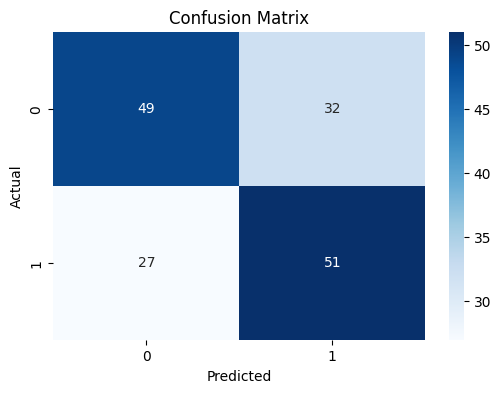

In [7]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

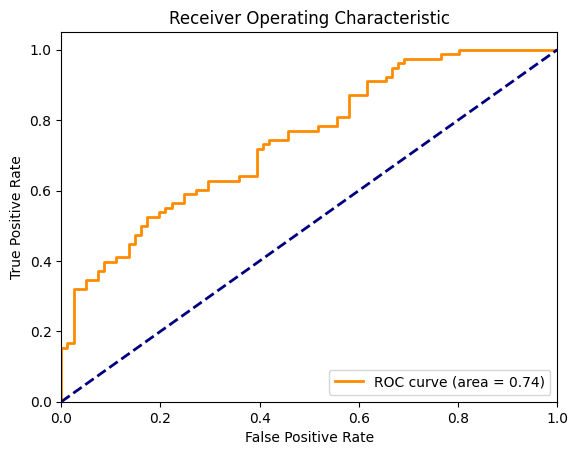

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 7. Feature Importance

Let's see which features the model relies on most.

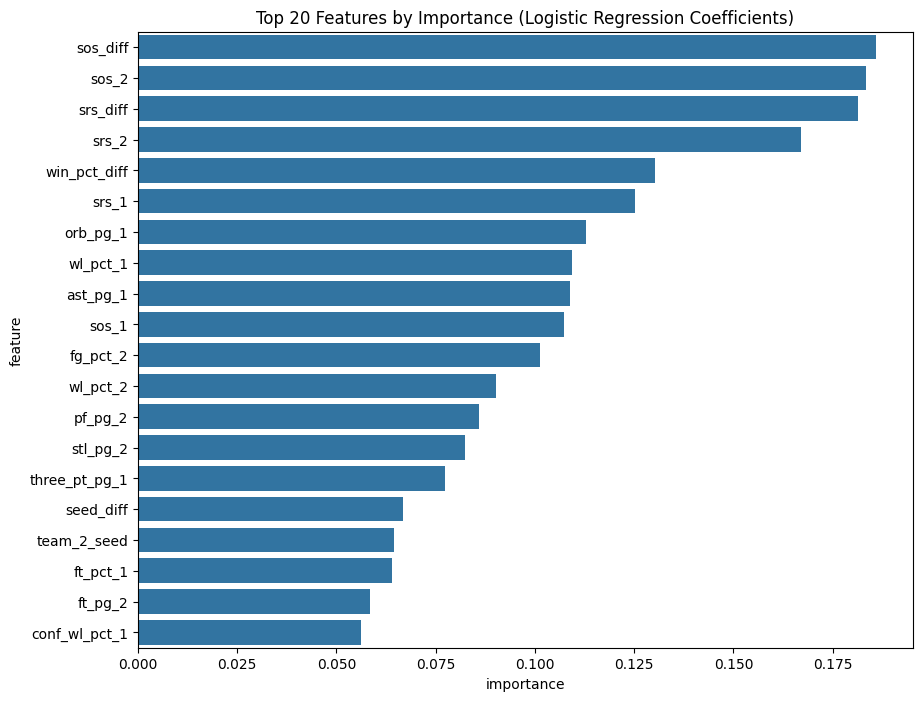

In [9]:
coeffs = best_model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'feature': features, 'importance': np.abs(coeffs)})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Features by Importance (Logistic Regression Coefficients)')
plt.show()

# We have trained our models, not experiment with them to produce your bracket!

In [10]:

shared.evaluate_tournament(df_team, best_model, features=features)


Evaluating Winner of  South
--- South  round  1 ---
Alabama 1  vs.  Hartford 16 (team 1 won= 1 )
Maryland 8  vs.  West Virginia 9 (team 1 won= 1 )
San Diego State 5  vs.  Charleston Southern 12 (team 1 won= 1 )
Virginia 4  vs.  Furman 13 (team 1 won= 1 )
Creighton 6  vs.  NC State 11 (team 1 won= 1 )
Baylor 3  vs.  UC Santa Barbara 14 (team 1 won= 1 )
Missouri 7  vs.  Utah State 10 (team 1 won= 1 )
Arizona 2  vs.  Princeton 15 (team 1 won= 1 )
--- South  round  2 ---
Alabama 1  vs.  Maryland 8 (team 1 won= 1 )
San Diego State 5  vs.  Virginia 4 (team 1 won= 1 )
Creighton 6  vs.  Baylor 3 (team 1 won= 0 )
Missouri 7  vs.  Arizona 2 (team 1 won= 0 )
--- South  round  3 ---
Alabama 1  vs.  San Diego State 5 (team 1 won= 1 )
Baylor 3  vs.  Arizona 2 (team 1 won= 0 )
--- South  round  4 ---
Alabama 1  vs.  Arizona 2 (team 1 won= 1 )
Winner of  South : ('Alabama', 1)
Evaluating Winner of  East
--- East  round  1 ---
Purdue 1  vs.  Texas Southern 16 (team 1 won= 1 )
Memphis 8  vs.  Florida At

D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer wa

Kansas 1  vs.  Arkansas 8 (team 1 won= 1 )
Saint Mary's (CA) 5  vs.  Connecticut 4 (team 1 won= 1 )
TCU 6  vs.  Gonzaga 3 (team 1 won= 0 )
Northwestern 7  vs.  UCLA 2 (team 1 won= 0 )
--- West  round  3 ---
Kansas 1  vs.  Saint Mary's (CA) 5 (team 1 won= 1 )
Gonzaga 3  vs.  UCLA 2 (team 1 won= 0 )
--- West  round  4 ---
Kansas 1  vs.  UCLA 2 (team 1 won= 0 )
Winner of  West : ('UCLA', 2)
Evaluating Winner of  FinalFour
--- FinalFour  round  1 ---
Alabama 1  vs.  Marquette 2 (team 1 won= 0 )
Houston 1  vs.  UCLA 2 (team 1 won= 0 )
--- FinalFour  round  2 ---
Marquette 2  vs.  UCLA 2 (team 1 won= 0 )
Winner of  FinalFour : ('UCLA', 2)
========= Bracket Winner =========
('UCLA', 2)


D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
D:\code\MachineLearningMarchMadness\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer wa